# Validate Motion State

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import fetch_data
import numpy as np
import correct_drift
import datetime

import importlib
importlib.reload(fetch_data)

<module 'fetch_data' from '/home/tyler/Documents/Matt3r/IMU_validation/fetch_data.py'>

Select Data

In [19]:
# Hamid data
# start_date_str = '2023-06-28'
# end_date_str = '2023-06-28'
start_date_str = '2023-07-07'
end_date_str = '2023-07-08'
organization_id = 'hamid'
can_k3y_id = '17700cf8'
imu_k3y_id = '17700cf8'

In [25]:
# Amir M data
start_date_str = '2023-06-29'
end_date_str = '2023-06-29'
organization_id = 'amirm'
can_k3y_id = 'c9a6b512'
imu_k3y_id = 'c9a6b512'

Collect the Data

In [3]:
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)

# compute the correction matrix for Hamid's data
GLOVE_TO_CONSOLE_MTX = np.array([[0, 0, 1], [0.0856, 0.9963, 0], [-0.9963, 0.0856, 0]])
S3_K3Y_VEH_ROT_MTX_CONSOLE = np.array([[1, 0, 0], [0, -1, 0], [0, 0, -1]])
S3_K3Y_VEH_ROT_MTX = np.matmul(S3_K3Y_VEH_ROT_MTX_CONSOLE, GLOVE_TO_CONSOLE_MTX)
CORRECTION_MATRIX = S3_K3Y_VEH_ROT_MTX_CONSOLE@np.linalg.inv(S3_K3Y_VEH_ROT_MTX)

if organization_id == 'hamid':
    acc_np = imu_df[['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)']].to_numpy()
    vehicle_ac = np.matmul(CORRECTION_MATRIX, acc_np[:, 1:].T)
    vehicle_ac_np = np.column_stack((acc_np[:,0], vehicle_ac.T))
    imu_df = pd.DataFrame(vehicle_ac_np, columns=['correct_timestamp', 'lr_acc(m/s^2)', 'bf_acc(m/s^2)', 'vert_acc(m/s^2)'])

# get the normalized acceleration
imu_df['norm_acc'] = np.sqrt(imu_df['lr_acc(m/s^2)']**2 + imu_df['bf_acc(m/s^2)']**2 + imu_df['vert_acc(m/s^2)']**2)

In [20]:
# use after Jul 7
event_dict = fetch_data.get_events(can_k3y_id, organization_id, start_date_str, end_date_str)
can_df = fetch_data.get_can_data(can_k3y_id, organization_id, start_date_str, end_date_str)
imu_df = fetch_data.get_imu_data(imu_k3y_id, organization_id, start_date_str, end_date_str)
imu_df['norm_acc'] = np.sqrt(imu_df['lr_acc(m/s^2)']**2 + imu_df['bf_acc(m/s^2)']**2 + imu_df['vert_acc(m/s^2)']**2)

In [18]:
print(can_df)

          timestamp  lr_acc  bf_acc  vert_acc  vert_w     lr_w     bf_w   
0      1.688772e+09     NaN     NaN       NaN     NaN      NaN      NaN  \
1      1.688772e+09     NaN     NaN       NaN -0.0126 -0.00600  0.00200   
2      1.688772e+09    0.22  0.0475  -0.21625     NaN      NaN      NaN   
3      1.688772e+09     NaN     NaN       NaN     NaN      NaN      NaN   
4      1.688772e+09     NaN     NaN       NaN -0.0111 -0.00575  0.00525   
...             ...     ...     ...       ...     ...      ...      ...   
26223  1.688773e+09     NaN     NaN       NaN     NaN      NaN      NaN   
26224  1.688800e+09     NaN     NaN       NaN     NaN      NaN      NaN   
26225  1.688800e+09     NaN     NaN       NaN     NaN      NaN      NaN   
26226  1.688800e+09     NaN     NaN       NaN     NaN      NaN      NaN   
26227  1.688800e+09     NaN     NaN       NaN     NaN      NaN      NaN   

       speed        lat       long  ap_state  
0      24.88        NaN        NaN       NaN  
1    

In [22]:
# define the rolling max
sample_size = 1
windows = 100
imu_df['rolling_acc'] = imu_df['norm_acc'].rolling(window=windows * sample_size).max().dropna()

Use the speed data to create stationary and driving states

In [21]:
# get the driving state data based on the CAN Server speed data

stationary_speed = 0.5
drive_duration = 0.5

speed_df = can_df[can_df['speed'].notna()].copy()
speed_df.reset_index(drop=True, inplace=True)
speed_df['driving'] = abs(speed_df['speed']) > stationary_speed
dr_start_times = speed_df[speed_df['driving'].astype(int).diff() == 1]['timestamp'].to_list()
dr_end_times = speed_df[speed_df['driving'].astype(int).diff() == -1]['timestamp'].to_list()

# get the driving states
dr_df_states = []
for i in range(min(len(dr_start_times),len(dr_end_times))):
    if dr_end_times[i] - dr_start_times[i] > drive_duration:
        dr_df_states.append(imu_df[(imu_df['correct_timestamp'] >= dr_start_times[i]) 
                        & (imu_df['correct_timestamp'] <= dr_end_times[i])])
dr_df = pd.concat(dr_df_states, ignore_index=True)

In [17]:
# get the driving state set based on the CAN Server event data

dr_df = imu_df
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    dr_df = dr_df[(dr_df['correct_timestamp'] <= ss_start_time) | (dr_df['correct_timestamp'] >= ss_end_time)]
dr_df_list = []
for state in event_dict['driving_state']:
    dr_start_time = state['start']
    dr_end_time = state['end']
    dr_df_list.append(dr_df[(dr_df['correct_timestamp'] >= dr_start_time) & (dr_df['correct_timestamp'] <= dr_end_time)])
dr_df = pd.concat(dr_df_list, ignore_index=True)

ValueError: No objects to concatenate

Compute the Similarity Using an Acceleration Threshold

In [24]:
def find_similarity(acc_cutoff):

    dr_proxy_df = imu_df[imu_df['rolling_acc'] > acc_cutoff]

    proxy_set = set(dr_proxy_df['correct_timestamp'].to_list())
    truth_set = set(dr_df['correct_timestamp'].to_list())

    # should be close to 1.00
    driving_similarity = len(truth_set.intersection(proxy_set)) / len(truth_set)
    stationary_similarity = len(truth_set.intersection(proxy_set)) / len(proxy_set)
    return driving_similarity, stationary_similarity

acc_range = np.linspace(0,1.5,151)
high_score = 0
high_acc = -1
for acc in acc_range:
    similarity_scores = find_similarity(acc)
    score = similarity_scores[0]**2 + similarity_scores[1]**2
    if score > high_score:
        high_score = score
        high_acc = acc

print(high_acc)
print(find_similarity(high_acc))

0.4
(0.9914825658770295, 0.6781005383195069)


In [25]:
result = find_similarity(0.35)
print([result[0], 1- result[1]])

[0.991862808471805, 0.3259167377316071]


Get Stationary State Data Metrics

In [41]:
# stitching together all stationary state data
imu_ss_states = []
can_ss_states = []
for state_num in range(len(event_dict['stationary_state'])):
    ss_start_time = event_dict['stationary_state'][state_num]['start']
    ss_end_time = event_dict['stationary_state'][state_num]['end']
    imu_ss_states.append(imu_df[(imu_df['correct_timestamp'] >= ss_start_time) 
                       & (imu_df['correct_timestamp'] <= ss_end_time)])
    can_ss_states.append(can_df[(can_df['timestamp'] >= ss_start_time) 
                        & (can_df['timestamp'] <= ss_end_time)])
imu_ss_df = pd.concat(imu_ss_states, ignore_index=True)
can_ss_df = pd.concat(can_ss_states, ignore_index=True)

print('left/right acceleration:')
print(f'imu mean: {imu_ss_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/front acceleration:')
print(f'imu mean: {imu_ss_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {imu_ss_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {imu_ss_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {imu_ss_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(imu_ss_df['lr_acc(m/s^2)']**2 + imu_ss_df['bf_acc(m/s^2)']**2 + imu_ss_df['vert_acc(m/s^2)']**2)
can_norm = np.sqrt(can_ss_df['lr_acc']**2 + can_ss_df['bf_acc']**2 + can_ss_df['vert_acc']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: 0.0061591948384565635
imu max: 0.024977570165179534
imu min: -0.02625098262464408

back/front acceleration:
imu mean: 0.6323008027283429
imu max: 1.2388400782071471
imu min: 0.024632237862115547

vertical acceleration:
imu mean: 0.16547404847209257
imu max: 0.3001436466581744
imu min: 0.05620613598856039

normalized acceleration:
imu mean: 0.6555028526364299
imu max: 1.2748287014515307
imu min: 0.06505078898637723


In [72]:
# driving state metrics

# dr_df = imu_df
# for state_num in range(len(event_dict['stationary_state'])):
#     ss_start_time = event_dict['stationary_state'][state_num]['start']
#     ss_end_time = event_dict['stationary_state'][state_num]['end']
#     dr_df = dr_df[(dr_df['correct_timestamp'] <= ss_start_time) | (dr_df['correct_timestamp'] >= ss_end_time)]

print('left/right acceleration:')
print(f'imu mean: {dr_df["lr_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["lr_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["lr_acc(m/s^2)"].min()}')
print('')
print('back/from acceleration:')
print(f'imu mean: {dr_df["bf_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["bf_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["bf_acc(m/s^2)"].min()}')
print('')
print('vertical acceleration:')
print(f'imu mean: {dr_df["vert_acc(m/s^2)"].mean()}')
print(f'imu max: {dr_df["vert_acc(m/s^2)"].max()}')
print(f'imu min: {dr_df["vert_acc(m/s^2)"].min()}')
print('')
print('normalized acceleration:')
imu_norm = np.sqrt(dr_df['lr_acc(m/s^2)']**2 + dr_df['bf_acc(m/s^2)']**2 + dr_df['vert_acc(m/s^2)']**2)
print(f'imu mean: {imu_norm.mean()}')
print(f'imu max: {imu_norm.max()}')
print(f'imu min: {imu_norm.min()}')

left/right acceleration:
imu mean: 0.044069647809420465
imu max: 6.32931139896168
imu min: -4.045026772044387

back/from acceleration:
imu mean: 0.13310492461098447
imu max: 5.747378041296793
imu min: -4.16723471812193

vertical acceleration:
imu mean: 0.09419809913344662
imu max: 4.894458958086332
imu min: -3.6047239625559415

normalized acceleration:
imu mean: 0.8694669774190821
imu max: 6.536425891773417
imu min: 0.007551239919562279


Display the Distribution of Acceleration in the Driving State

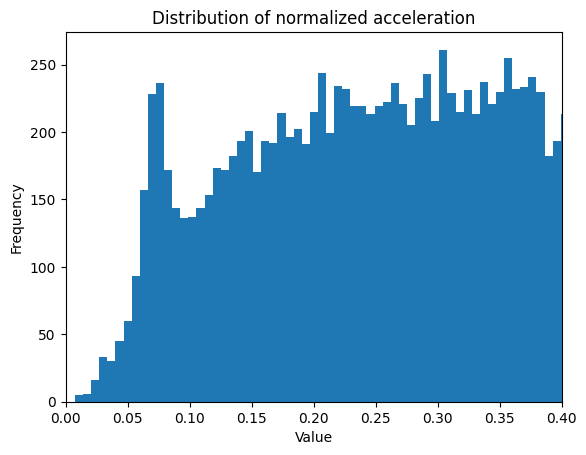

In [7]:
# Plot the distribution of column 'A'
plt.hist(dr_df['norm_acc'], bins=1000)  # Adjust the number of bins as needed
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of normalized acceleration')
plt.xlim(0,0.4)
plt.show()

Plot the Acceleration vs. the Speed

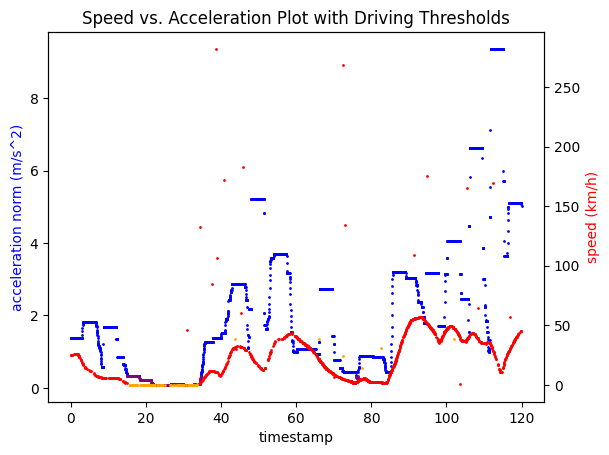

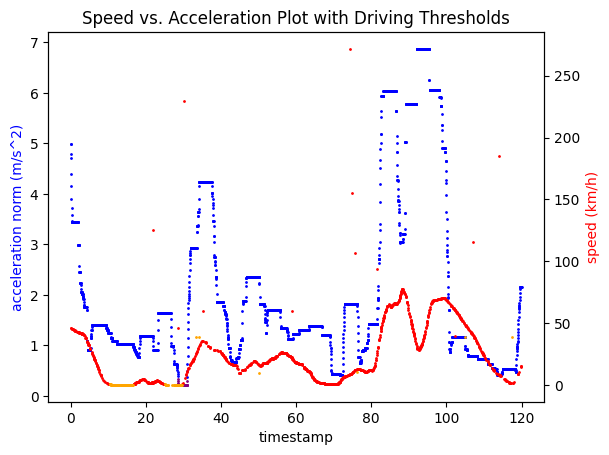

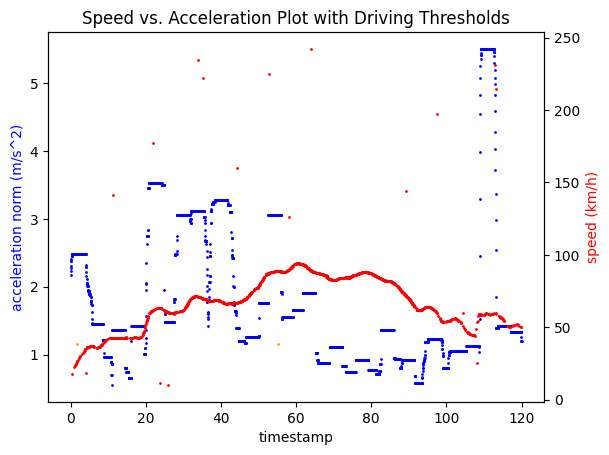

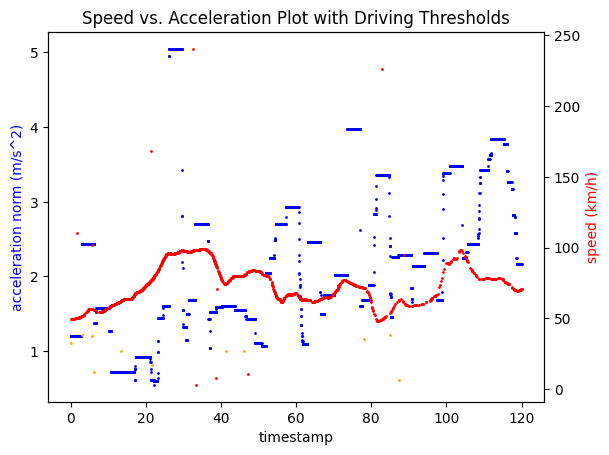

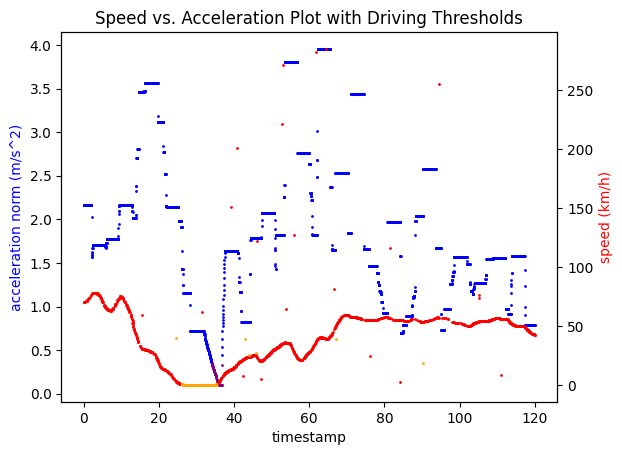

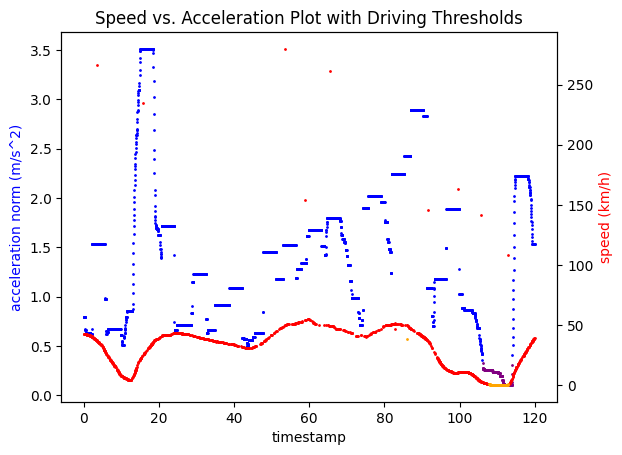

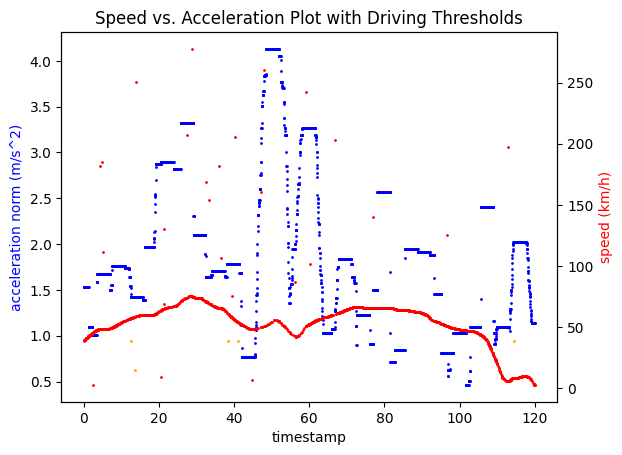

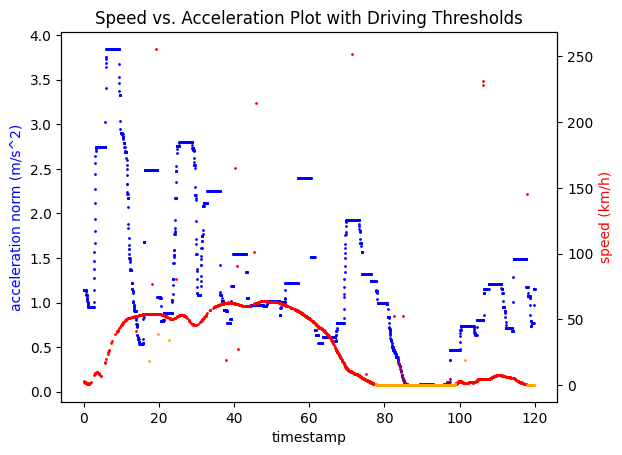

In [23]:
df = imu_df
# y_data = 'norm_acc'
y_data = 'rolling_acc'
acc_cutoff = 0.35

window = 120
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = df[(df['correct_timestamp'] >= dr_start_time) 
                        & (df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            fig, ax1 = plt.subplots()

            acc_dr = dr_motion[dr_motion[y_data] > acc_cutoff]
            acc_ss = dr_motion[dr_motion[y_data] <= acc_cutoff]
            can_dr = can_motion[can_motion['speed'] > 0.5]
            can_ss = can_motion[can_motion['speed'] <= 0.5]

            ax1.scatter(x=acc_dr['correct_timestamp'] - dr_start_time + window, y=acc_dr[y_data], s=1, color='blue')
            ax1.scatter(x=acc_ss['correct_timestamp'] - dr_start_time + window, y=acc_ss[y_data], s=1, color='purple')
            ax1.set_xlabel('timestamp')
            ax1.set_ylabel('acceleration norm (m/s^2)', color='blue')

            ax2 = ax1.twinx()
            ax2.scatter(can_dr['timestamp'] - dr_start_time + window, abs(can_dr['speed']), color='red', s=1)
            ax2.scatter(can_ss['timestamp'] - dr_start_time + window, abs(can_ss['speed']), color='orange', s=1)
            ax2.set_ylabel('speed (km/h)', color='red')
            
            plt.title('Speed vs. Acceleration Plot with Driving Thresholds')

            plt.show()

Filter Only Driving States

11


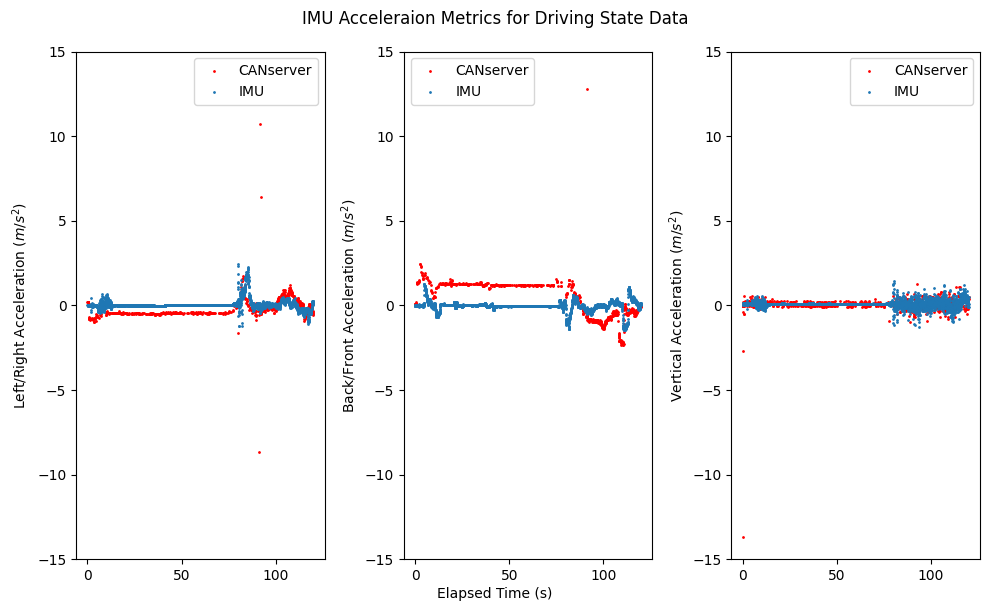

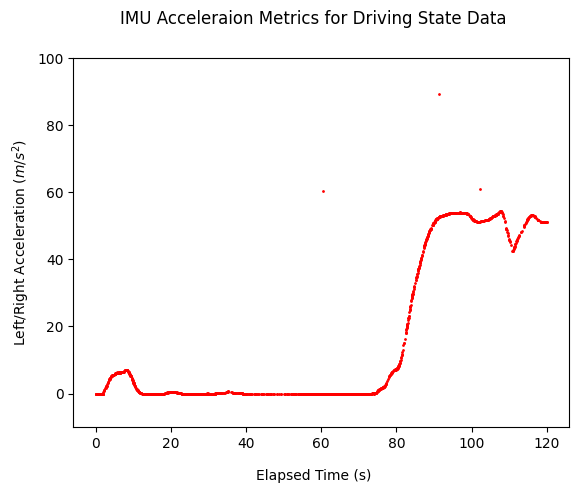

12


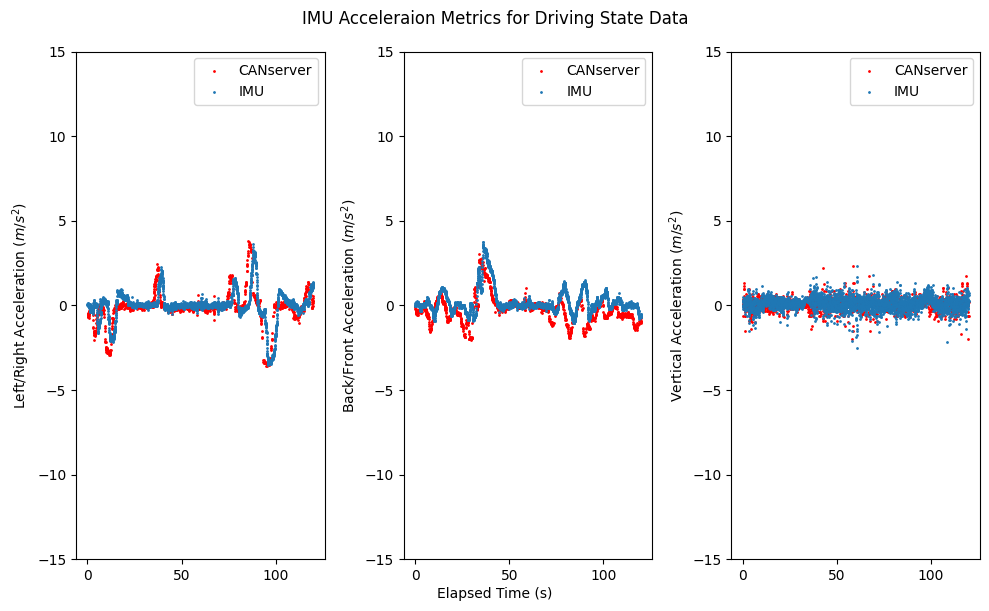

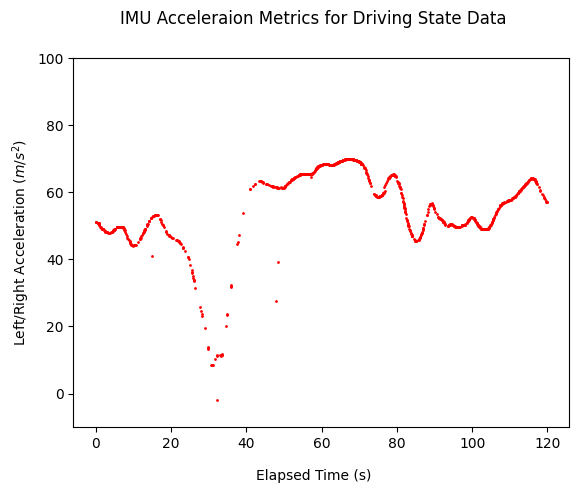

13


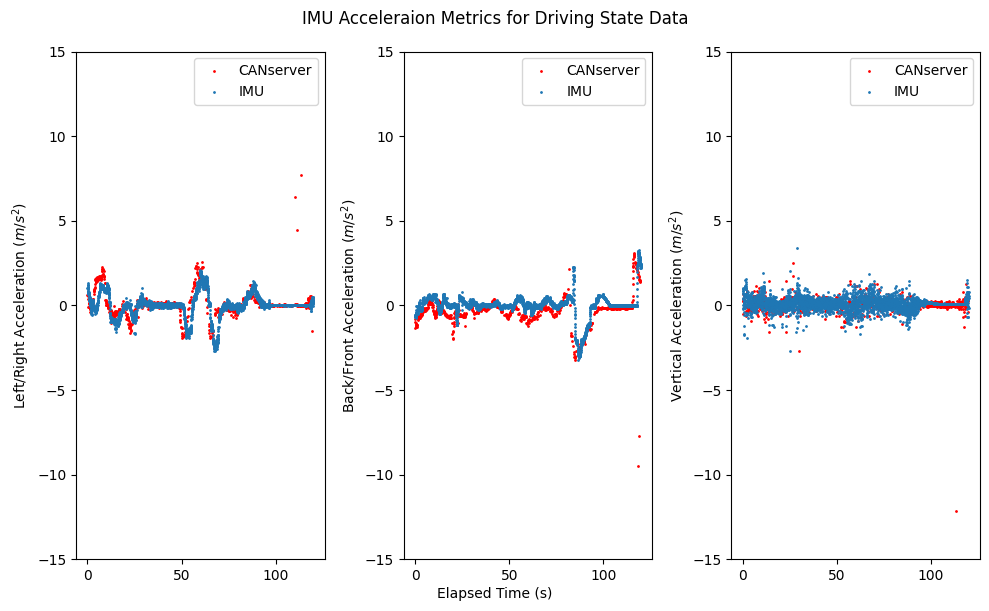

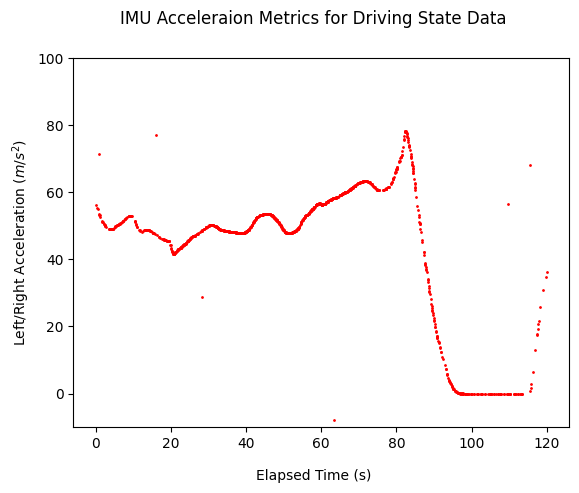

14


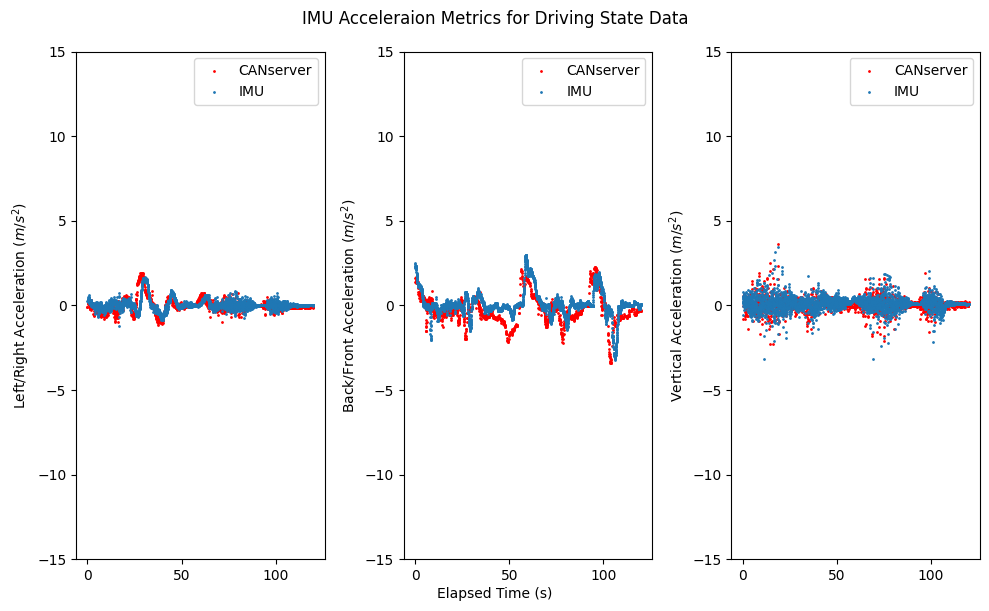

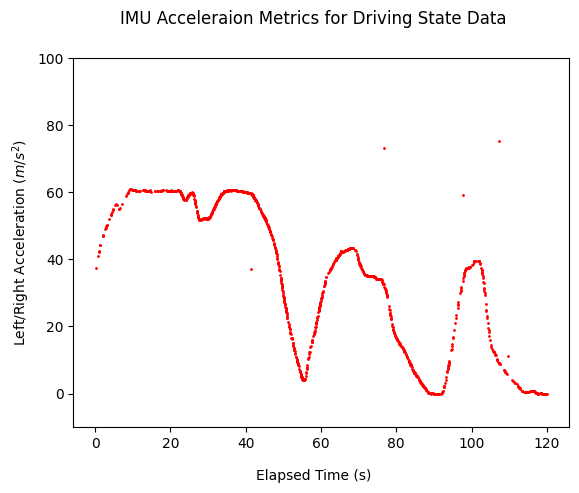

15


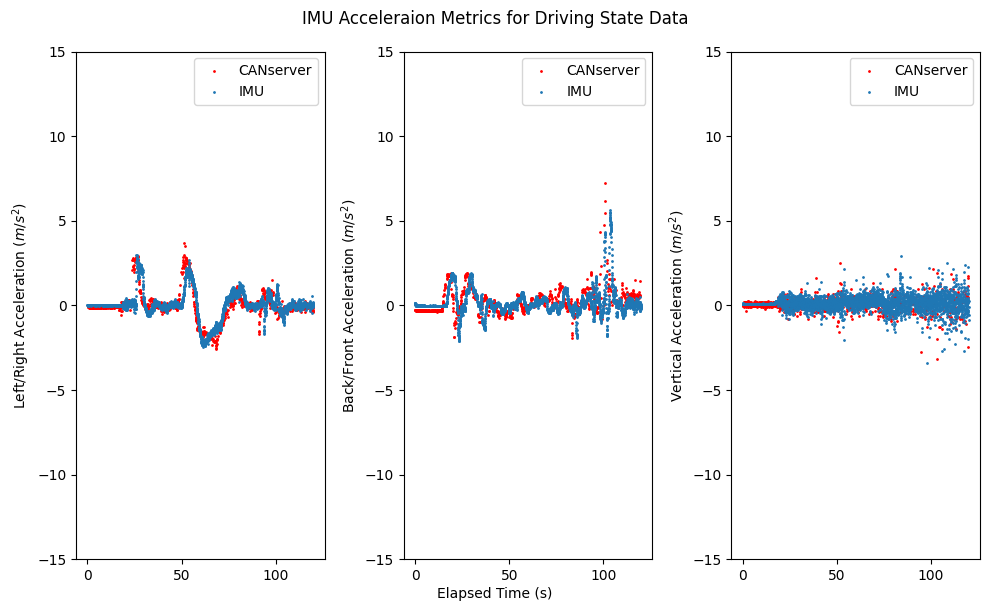

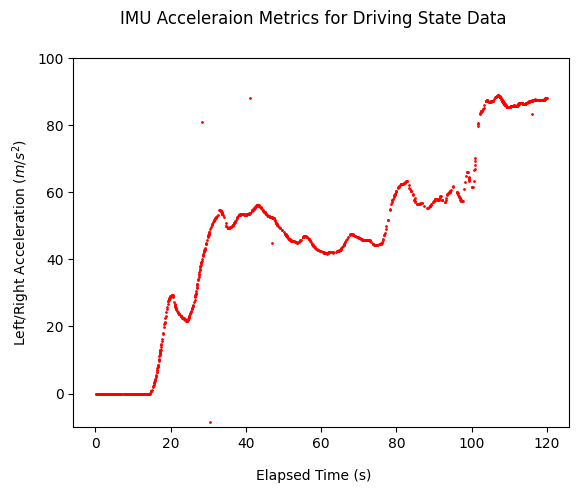

16


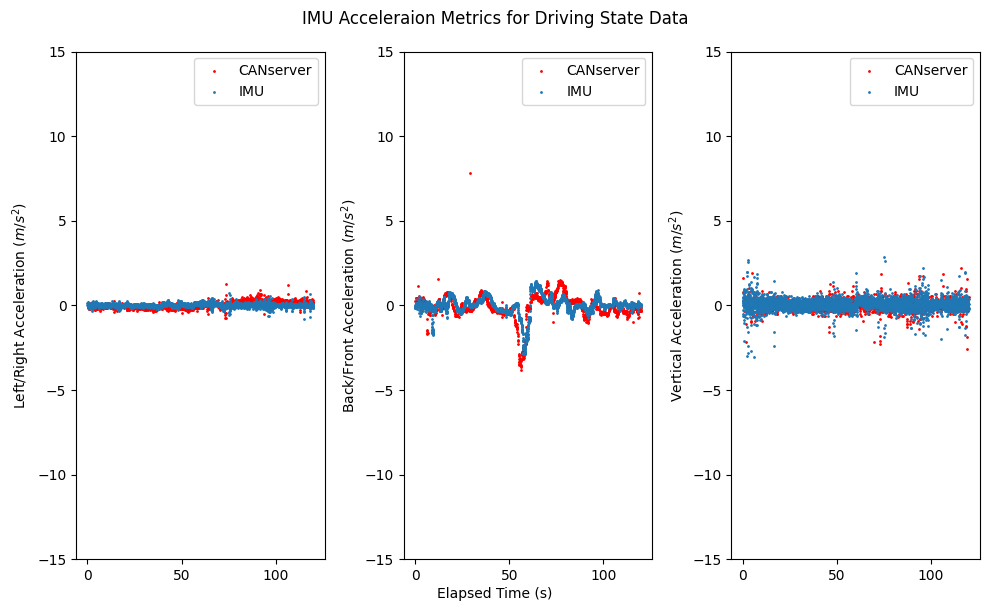

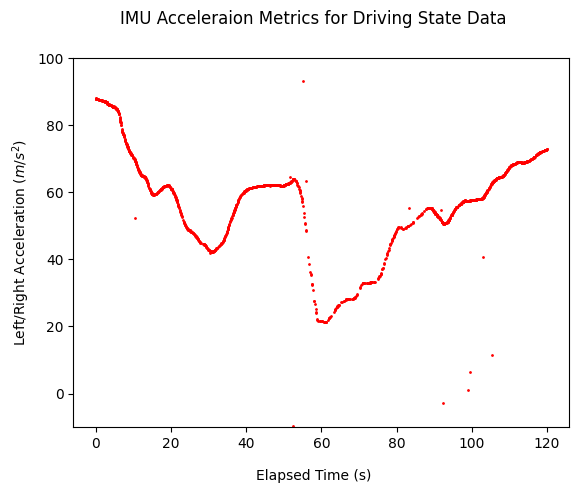

17


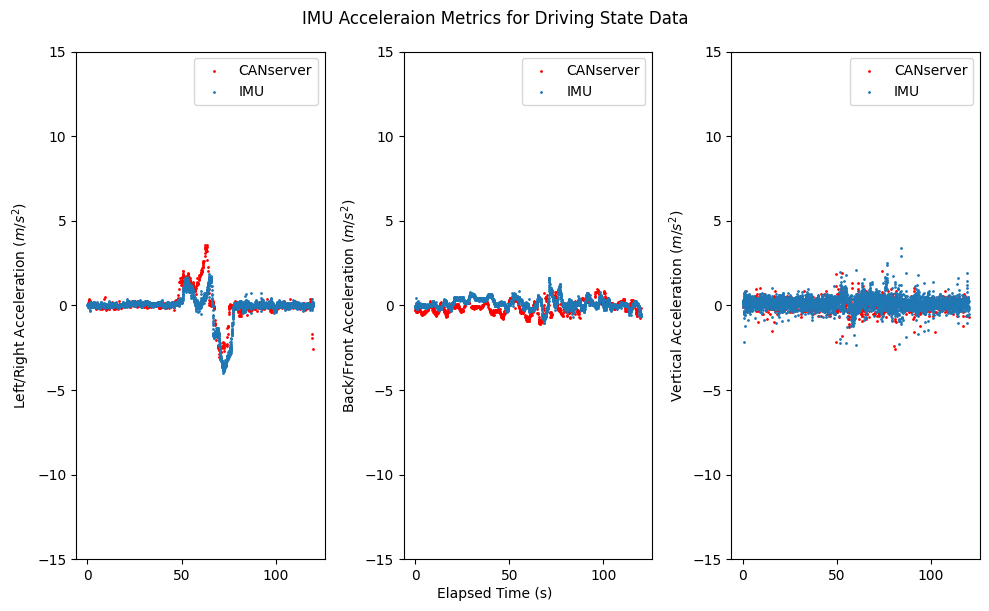

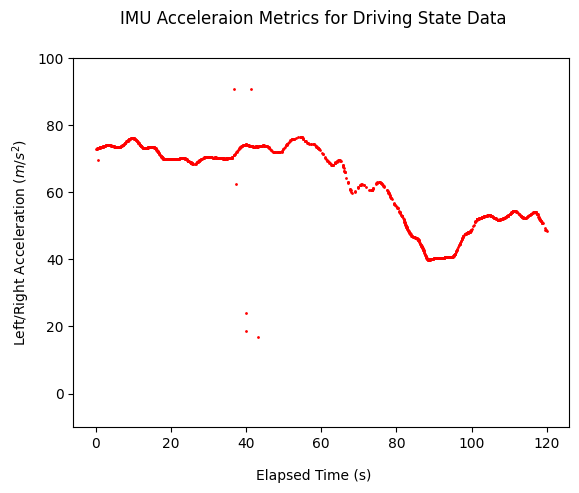

18


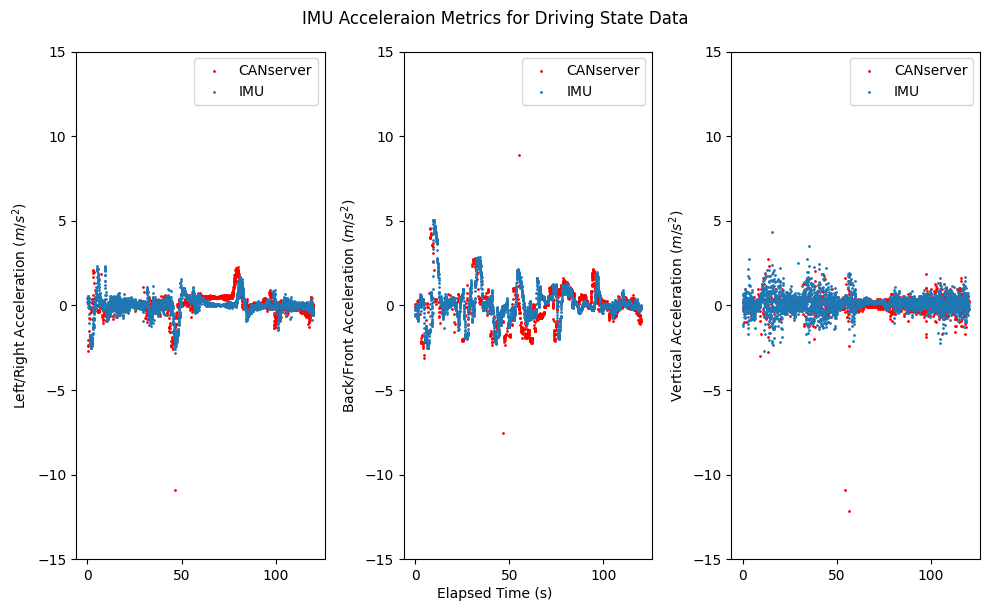

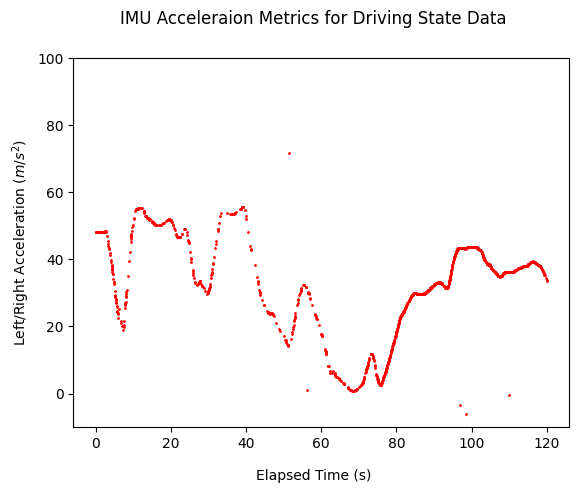

19


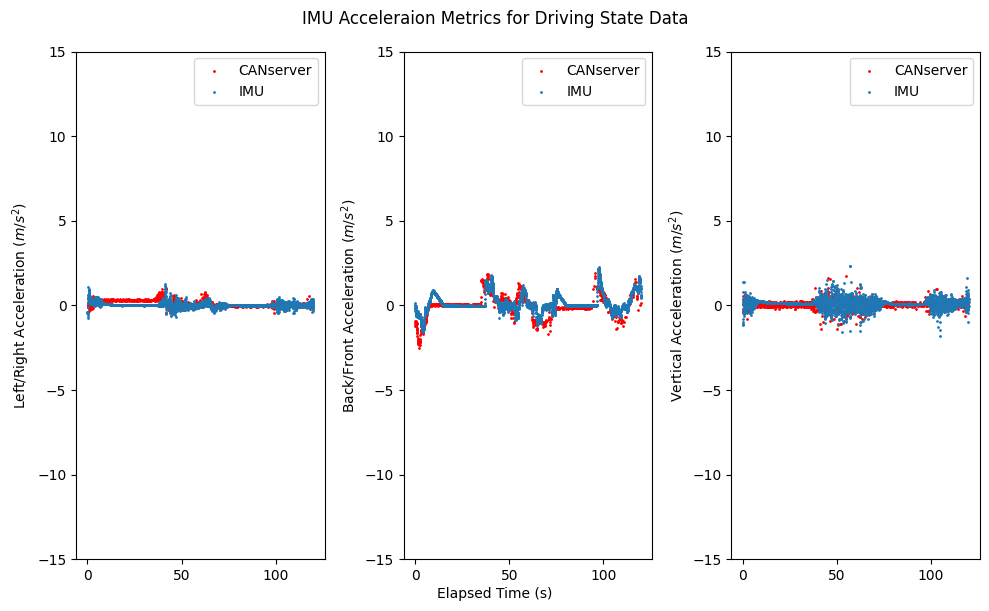

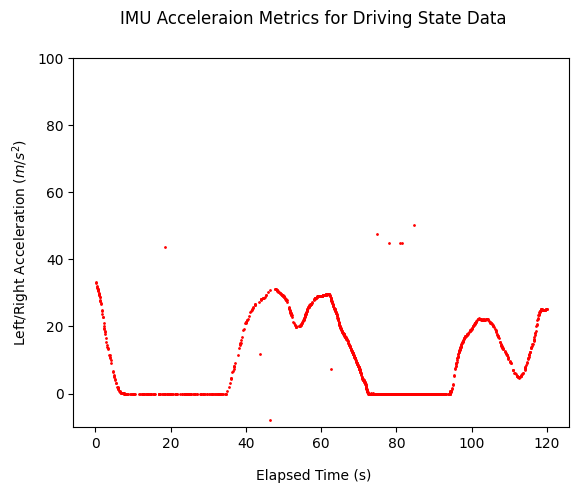

20


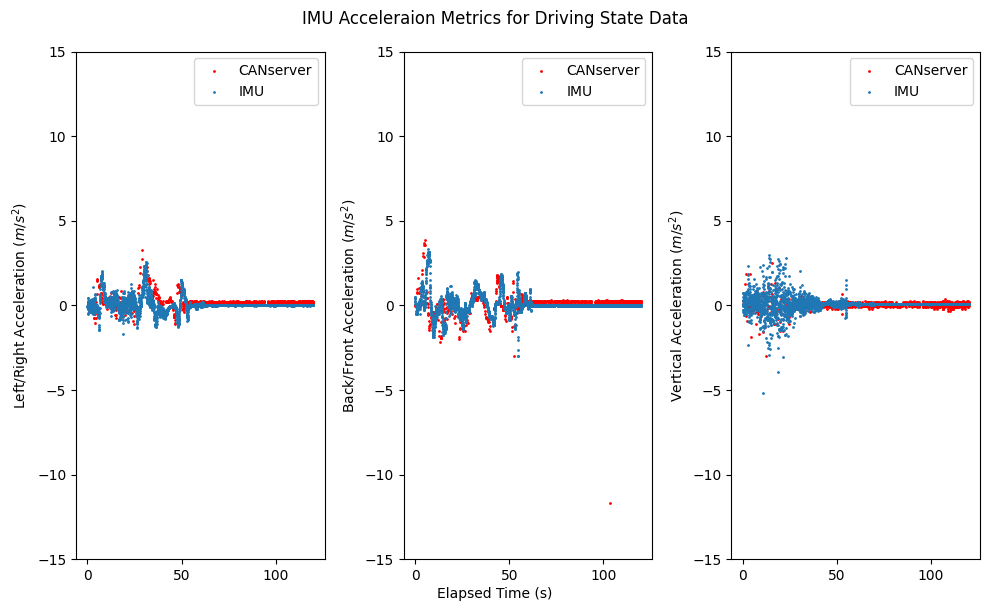

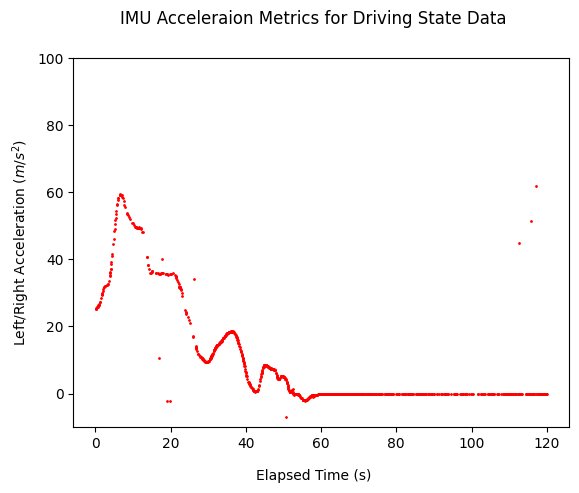

21


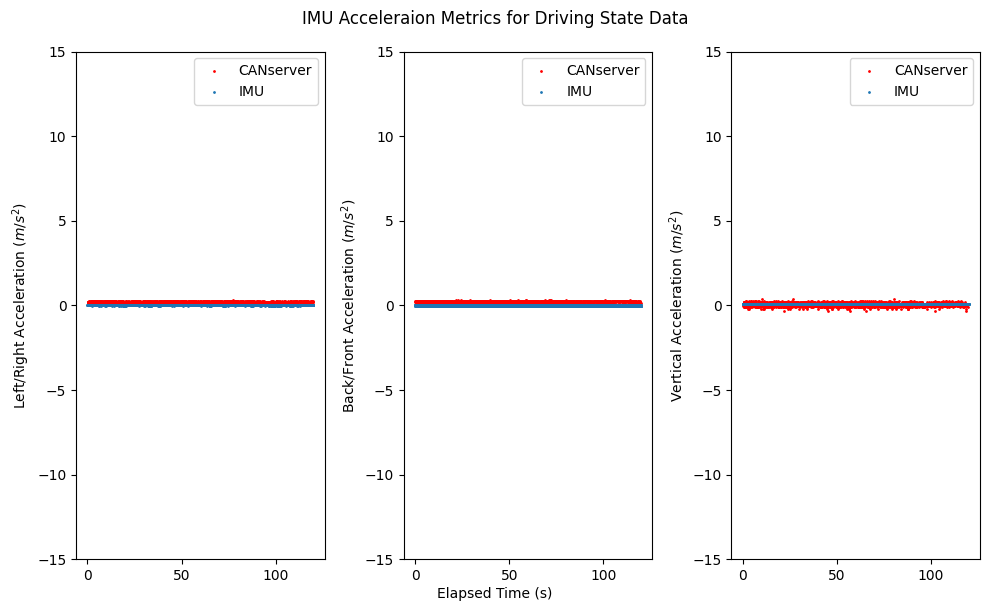

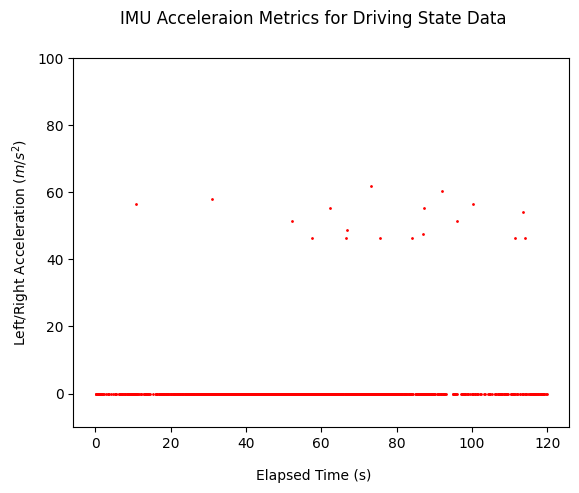

22


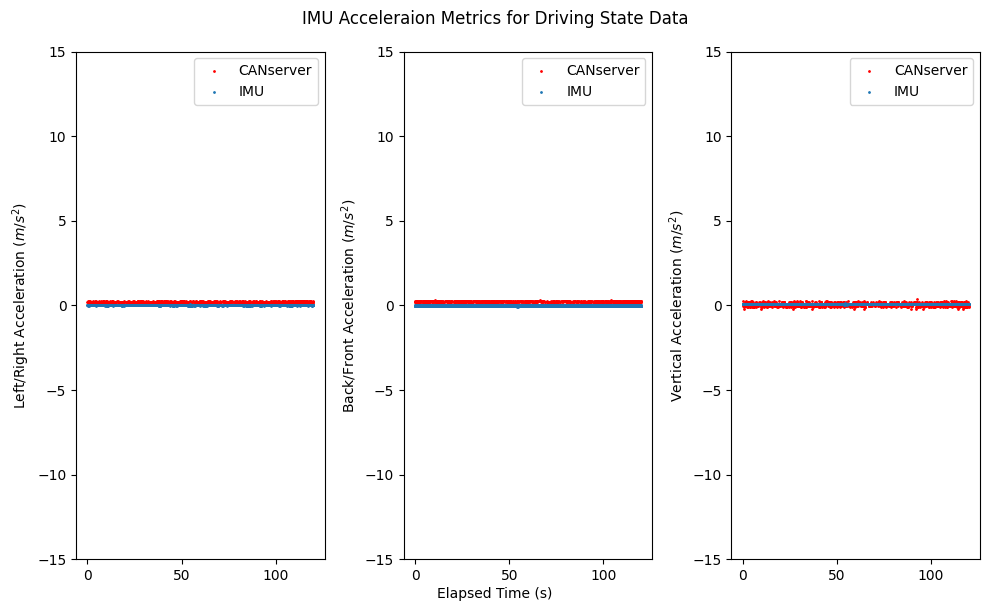

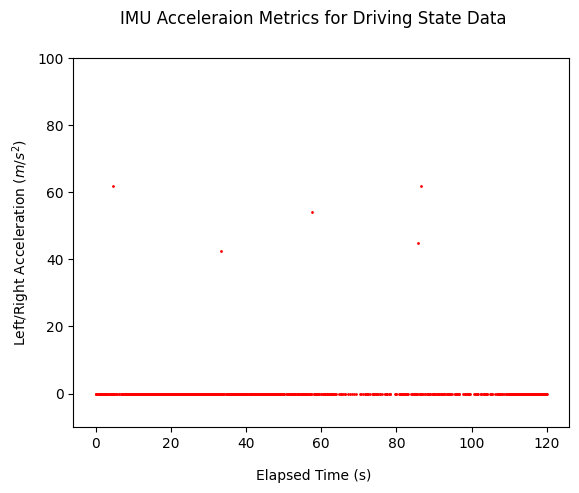

23


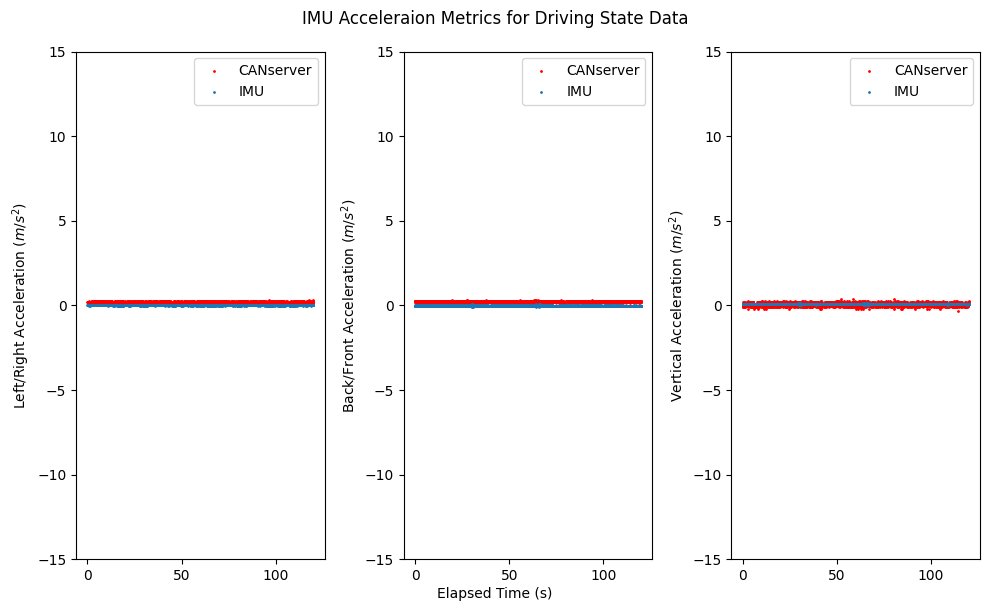

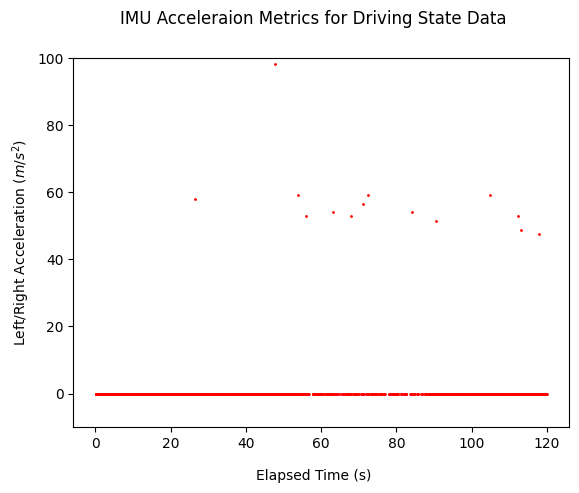

24


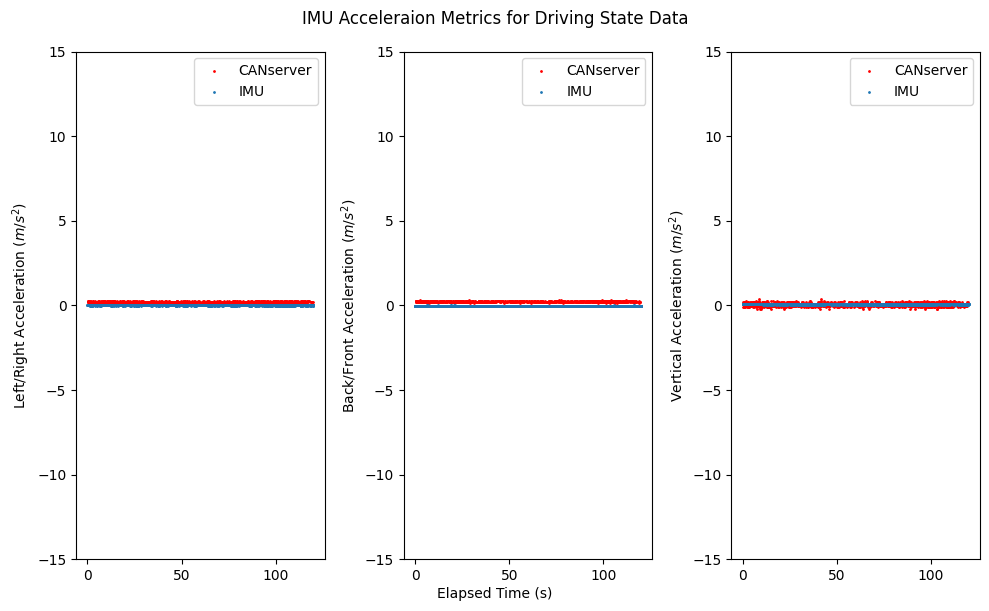

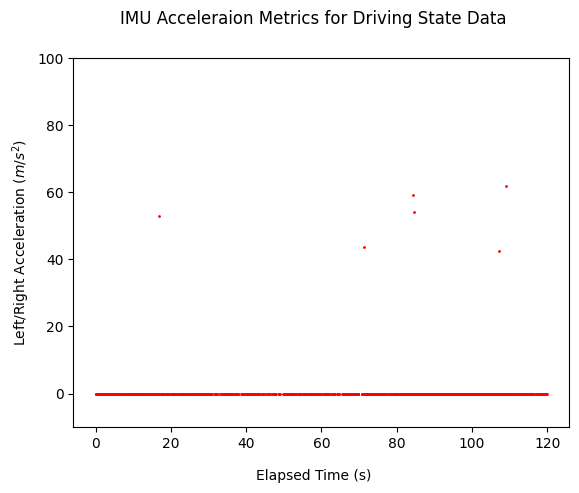

25


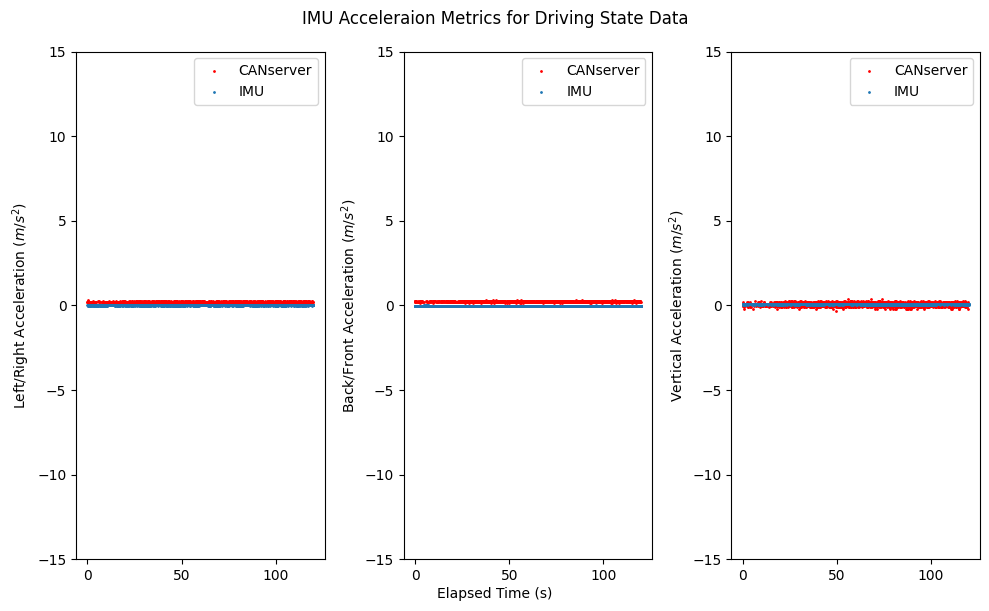

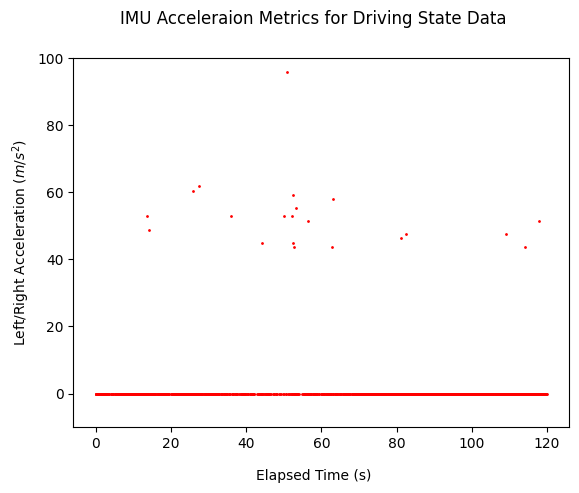

26


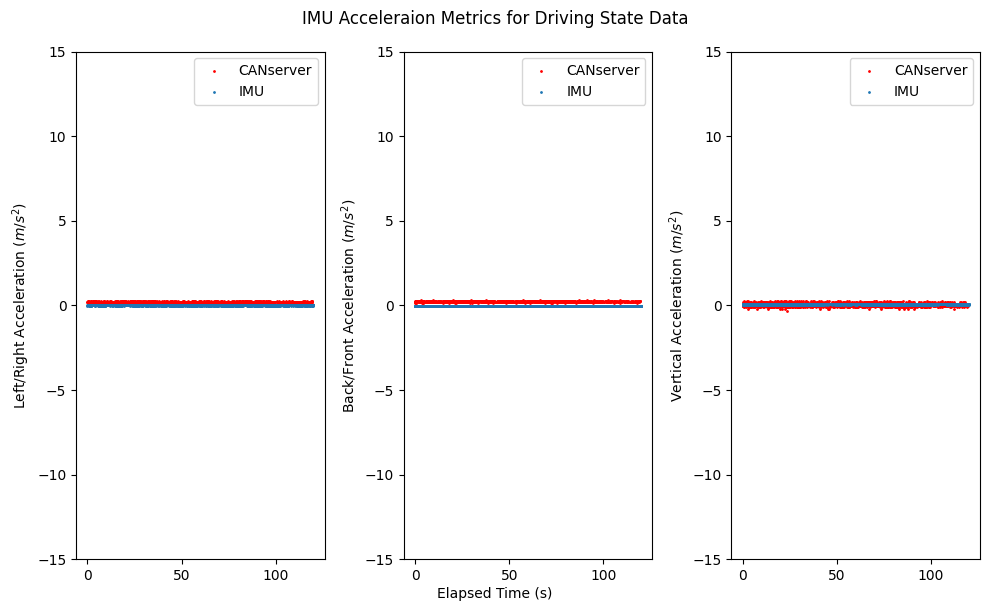

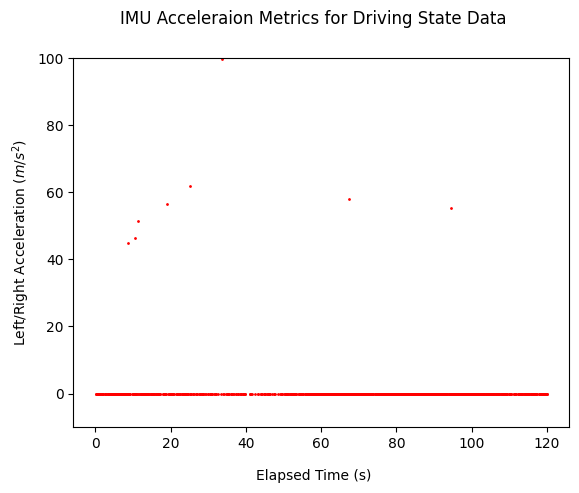

27


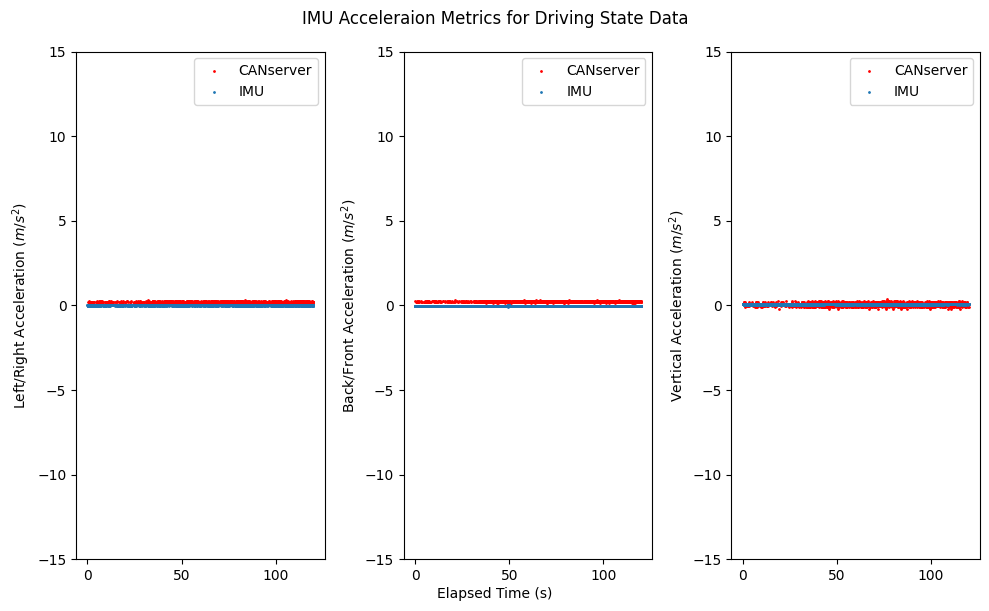

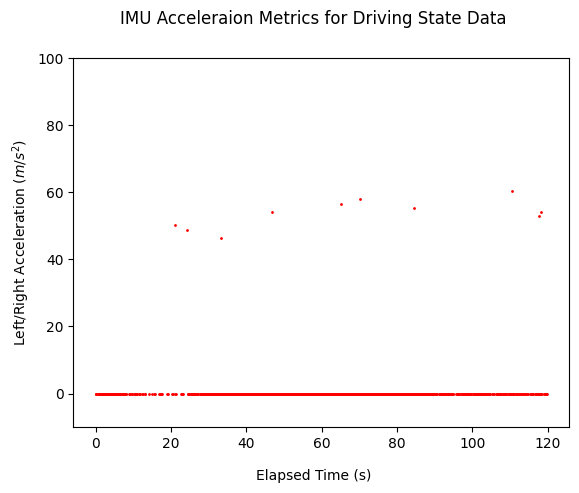

28


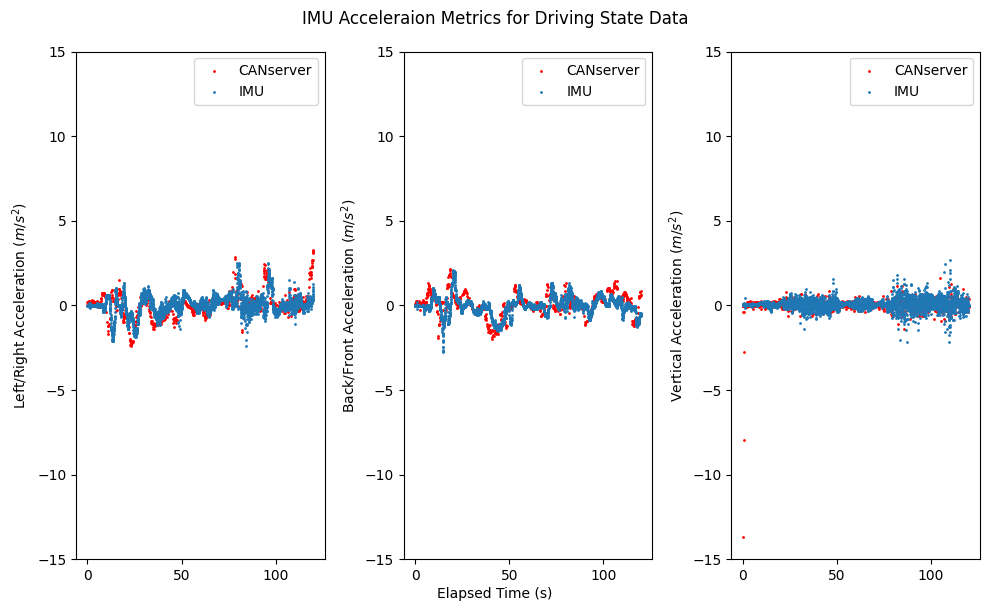

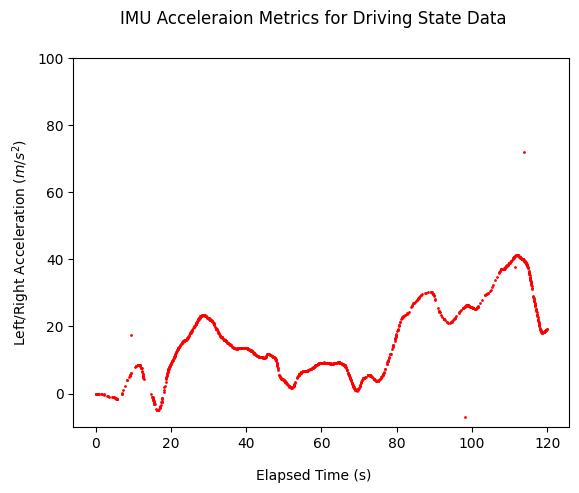

29


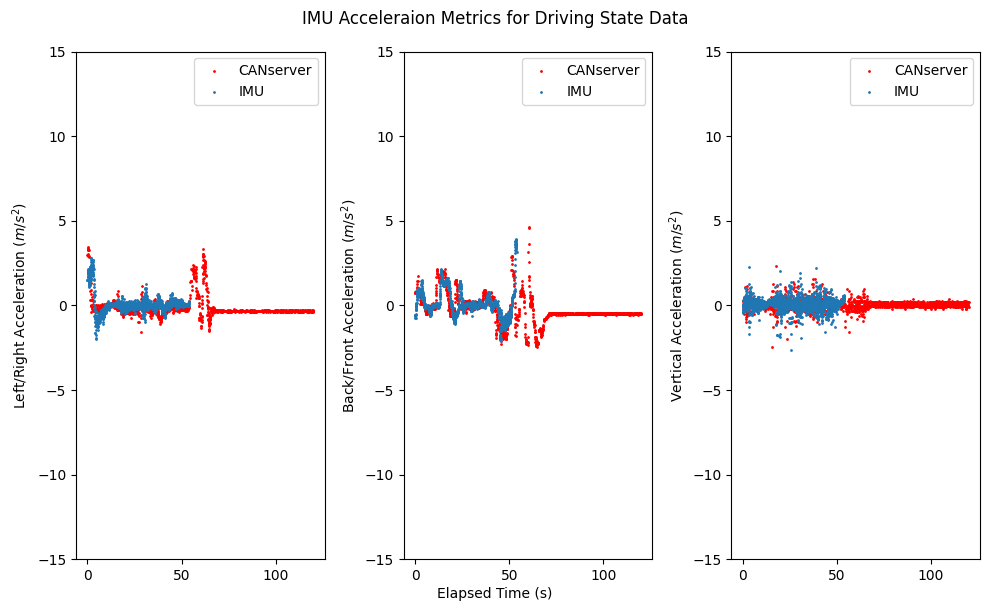

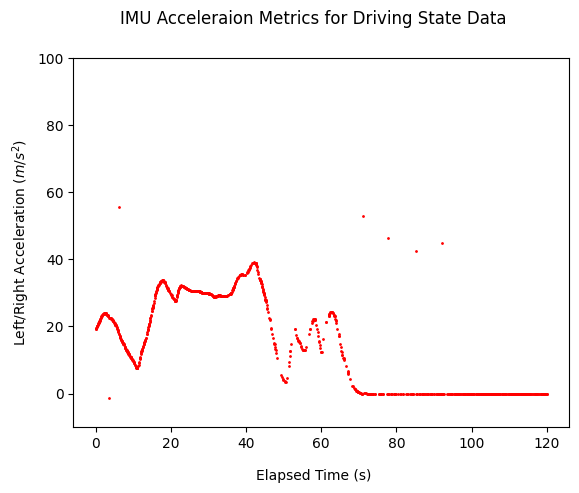

32


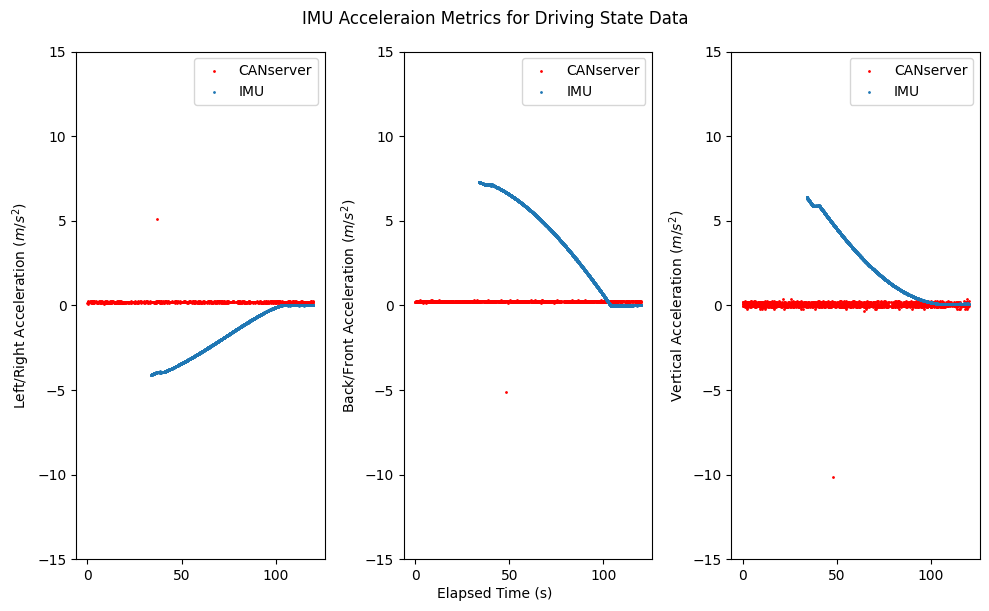

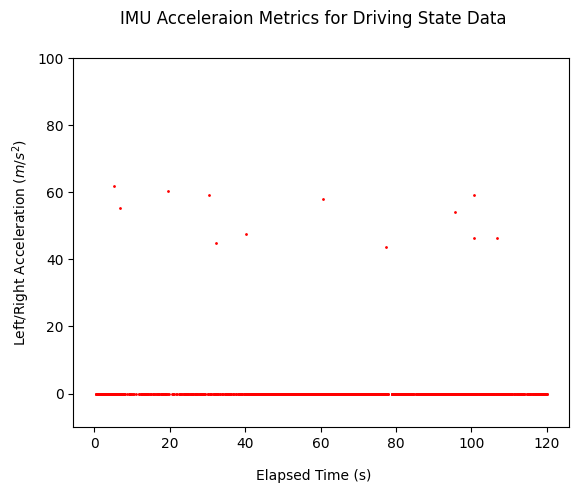

33


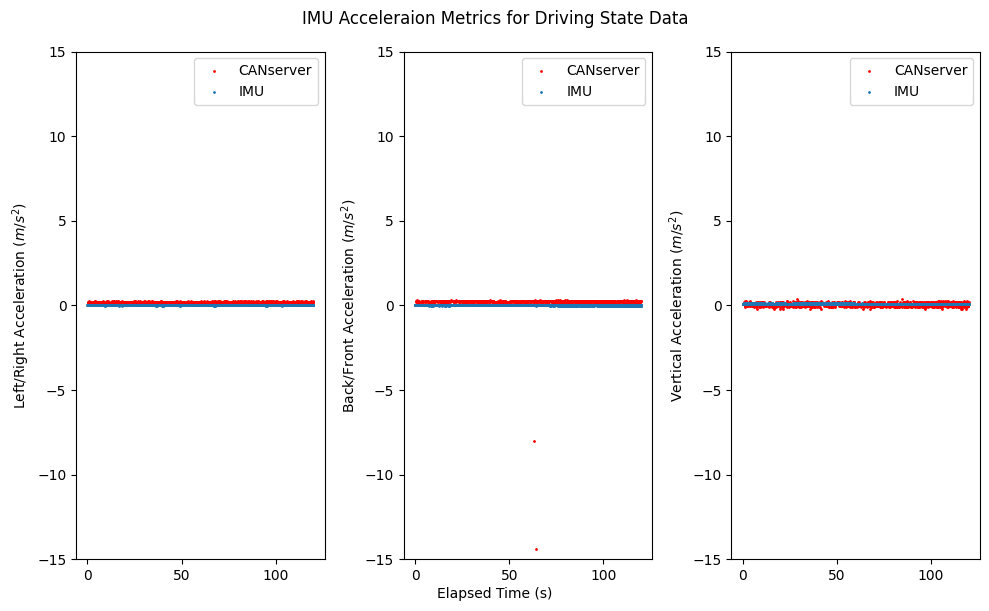

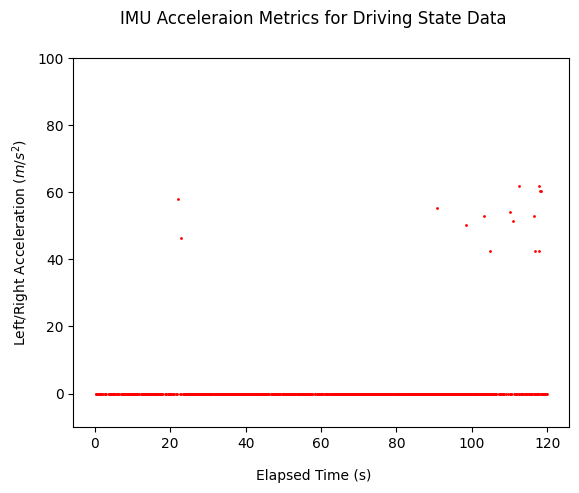

In [33]:
# Check the speed of the car

# df = dr_proxy_df
df = imu_df

window = 120
count = 0

for state_num in range(len(event_dict['driving_state'])):
    dr_start_time = event_dict['driving_state'][state_num]['start']
    dr_end_time = event_dict['driving_state'][state_num]['end']

    while (dr_end_time - dr_start_time > window):
        dr_motion = df[(df['correct_timestamp'] >= dr_start_time) 
                        & (df['correct_timestamp'] <= dr_start_time + window)]
        can_motion = can_df[(can_df['timestamp'] >= dr_start_time) 
                            & (can_df['timestamp'] <= dr_start_time + window)]
        dr_start_time += window

        count += 1
        # if ((len(dr_motion) != 0) and (len(can_motion) != 0) and (count < 20)):
        if ((len(dr_motion) != 0) and (len(can_motion) != 0)):
            print(count)
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

            fig.set_size_inches(10,6)

            ax1.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=-can_motion['lr_acc'], s=1, color='red', label='CANserver')
            ax1.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['lr_acc(m/s^2)'], s=1, label='IMU')
            ax1.set_ylim(-15,15)

            ax2.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['bf_acc'], s=1, color='red', label='CANserver')
            ax2.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['bf_acc(m/s^2)'], s=1, label='IMU')
            ax2.set_ylim(-15,15)

            ax3.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['vert_acc'], s=1, color='red', label='CANserver')
            ax3.scatter(x=dr_motion['correct_timestamp'] - dr_start_time + window, y=dr_motion['vert_acc(m/s^2)'], s=1, label='IMU')
            ax3.set_ylim(-15,15)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax1.set_ylabel("Left/Right Acceleration ($m/s^2$)")
            ax2.set_ylabel("Back/Front Acceleration ($m/s^2$)")
            ax3.set_ylabel("Vertical Acceleration ($m/s^2$)")

            ax1.legend()
            ax2.legend()
            ax3.legend()
            plt.tight_layout()
            plt.show()

            fig, ax = plt.subplots()

            ax.scatter(x=can_motion['timestamp'] - dr_start_time + window, y=can_motion['speed'], s=1, color='red', label='CANserver')
            ax.set_ylim(-10,100)

            fig.suptitle("IMU Acceleraion Metrics for Driving State Data")
            fig.text(0.5, 0.0, 'Elapsed Time (s)', ha='center')

            ax.set_ylabel("Left/Right Acceleration ($m/s^2$)")

            plt.show()